# U-net model with attention
This notebook shows the basic U-net plus the attention block used for the segmentation task and consists of 4 blocks for the encoder and 4 blocks for the decoder. Each block has stack = 2 and consists of the sequence of layers: Convolution, Batch Normalisation and Activation. Finally, a last block is called up in the bottleneck.

The attention mechanism is inserted into each decoder block.


In [ ]:
from google.colab import drive
drive.mount("/gdrive")

%cd /gdrive/My Drive/Colab Notebooks/AN2DL/Homework 2/Models
#%cd /gdrive/My Drive/Homework 2

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/1nsevQt0AHkv619Fg5omWFTVxhMjZS3lK/Homework 2/Models


In [ ]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


In [ ]:
seed = 42

**Load dataset**

In [ ]:
data = np.load("mars_for_students_processed.npz")

X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128)


In [ ]:
# Check color value of images
print(f"Min value: {np.min(X_train)}")
print(f"Max value: {np.max(X_train)}")

Min value: 2.0
Max value: 254.0


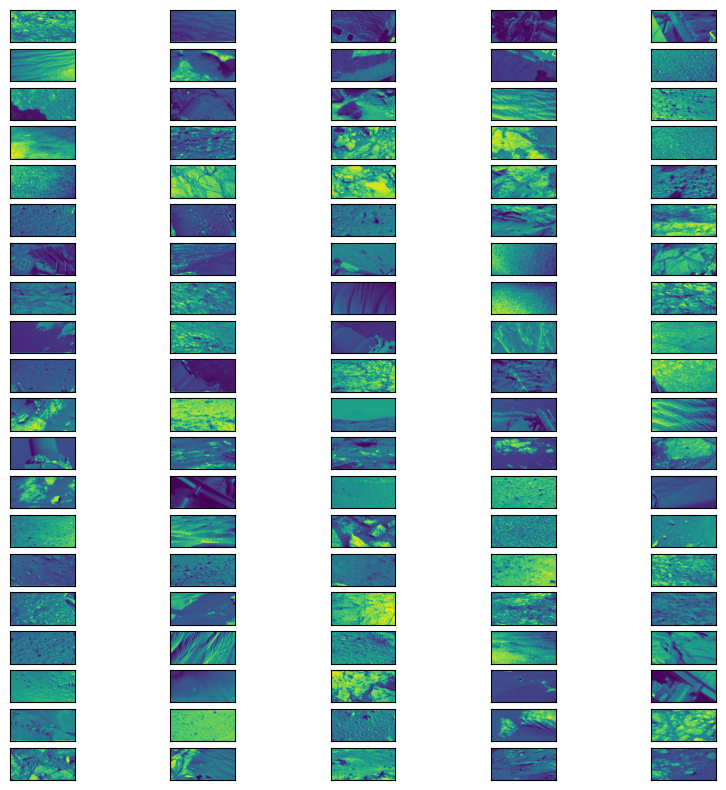

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(20, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
plt.show()

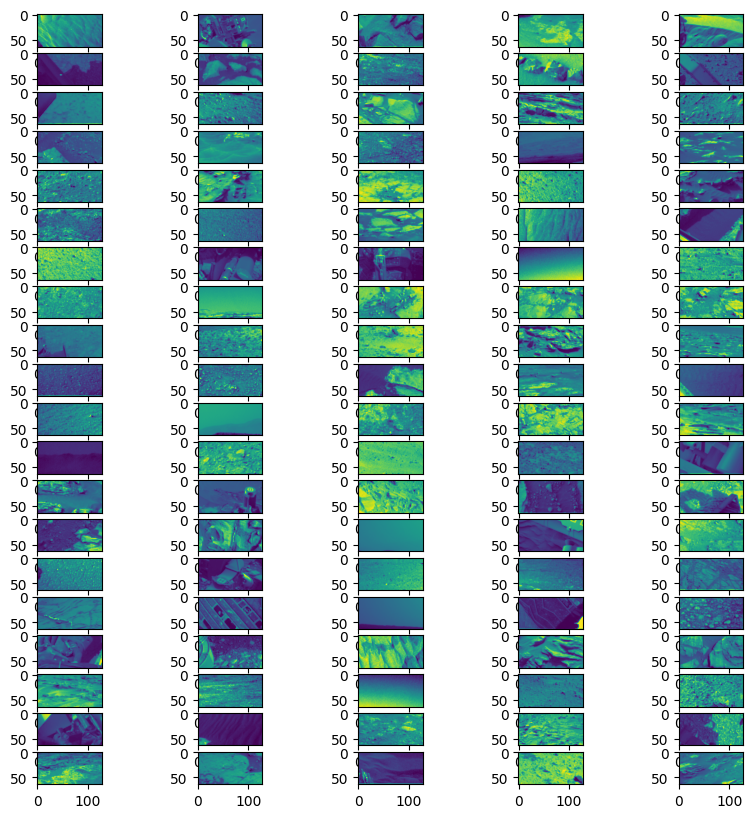

In [ ]:
# Visualize 25 image of X_test
plt.figure(figsize=(10,10))
for i in range(100):
    plt.subplot(20, 5, i + 1)
    plt.grid(False)
    plt.imshow(X_test[i+2000])
plt.show()

In [ ]:
from matplotlib.colors import ListedColormap

# Define colors for each class
class_colors = {
    0: "black",     # Background
    1: "brown",     # Soil
    2: "gray",      # Bedrock
    3: "yellow",    # Sand
    4: "darkgreen"  # Big Rock
}
cmap = ListedColormap([class_colors[key] for key in sorted(class_colors.keys())])

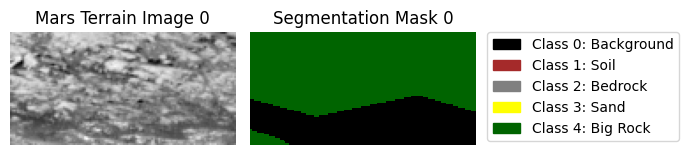

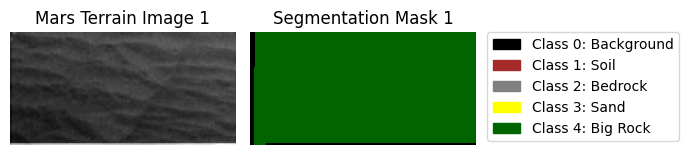

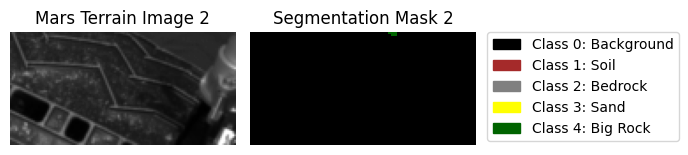

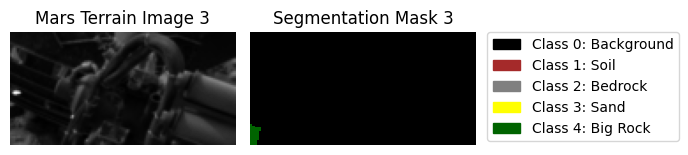

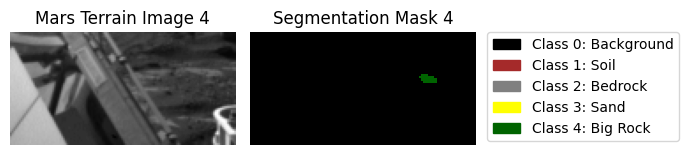

In [ ]:
# Prepare the legend
import matplotlib.patches as mpatches
legend_patches = [mpatches.Patch(color=class_colors[i], label=f"Class {i}: {label}")
                  for i, label in enumerate(["Background", "Soil", "Bedrock", "Sand", "Big Rock"])]

# Display a range of images
def display_images_with_masks(X_train, y_train, start, end):
    for i in range(start, end):
        image = X_train[i]
        mask = y_train[i]

        # Plot the image and mask
        plt.figure(figsize=(7, 5))

        # Grayscale image
        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap="gray")
        plt.title(f"Mars Terrain Image {i}")
        plt.axis("off")

        # Mask with class colors
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap=cmap, interpolation="none")
        plt.title(f"Segmentation Mask {i}")
        plt.axis("off")

        # Add legend
        plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.tight_layout()
        plt.show()

# Call the function for a range of images
display_images_with_masks(X_train, y_train, start=0, end=5)

## Dataset creation

**Parameters**

In [ ]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-4

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

**Make dataset**

In [ ]:
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    # If no seed is provided, generate one using TensorFlow
    if seed is None:
        seed = tf.random.uniform([], 0, 1000000, dtype=tf.int32)

    flip_prob = tf.random.uniform([], 0, 1, seed=seed)  # Random float between 0 and 1

    # Flip the image and label if the random probability is greater than 0.5
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )


    # Ensure label has 3 dimensions (height, width, 1)
    label = tf.expand_dims(label, axis=-1)
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )

    return image, tf.squeeze(label, axis=-1)

@tf.function
def random_brightness(image, max_delta=0.2):
    """Apply random brightness adjustment."""
    return tf.image.random_brightness(image, max_delta=max_delta)

@tf.function
def random_contrast(image, lower=0.7, upper=1.3):
    """Apply random contrast adjustment."""
    return tf.image.random_contrast(image, lower=lower, upper=upper)

In [ ]:
# Define function for creating the dataset
def make_dataset(X_in, y_in, batch_size, shuffle=True, augment=False, seed=None):

    # Create a tf.data.Dataset from X_train and y_train
    dataset = tf.data.Dataset.from_tensor_slices((X_in, y_in))

    # Shuffle the dataset if shuffle is True
    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Apply preprocessing
    dataset = dataset.map(
        lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.int32)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Optionally apply data augmentation
    if augment:
        dataset = dataset.map(
            lambda x, y: random_flip(random_contrast(random_brightness(x)), y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)

    # Prefetch for better performance
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
def make_test_dataset(X_test, batch_size, shuffle=False, seed=None):

    # Create a tf.data.Dataset from X_test
    dataset = tf.data.Dataset.from_tensor_slices(X_test)

    # Shuffle the dataset if shuffle is True (not necessary for testing, but optional)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Apply preprocessing
    dataset = dataset.map(
        lambda x: tf.cast(x, tf.float32) / 255.0,  # Normalize image to [0, 1]
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)

    # Prefetch for better performance
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


**Split train and validation set**

In [ ]:
# Split train and val set
from sklearn.model_selection import train_test_split

train_img, val_img, train_lbl, val_lbl = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

# Print shape
print(f"Train images shape: {train_img.shape}")
print(f"Train labels shape: {train_lbl.shape}")
print(f"Validation images shape: {val_img.shape}")
print(f"Validation labels shape: {val_lbl.shape}")

Train images shape: (2004, 64, 128, 1)
Train labels shape: (2004, 64, 128)
Validation images shape: (501, 64, 128, 1)
Validation labels shape: (501, 64, 128)


In [ ]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=False,
    seed=seed
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_dataset = make_test_dataset(
    X_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
)
print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128)
Labels dtype: <dtype: 'int32'>


## Define model

**Block defintion**

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same',
                        # kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                        # bias_regularizer=tf.keras.regularizers.l2(1e-4),
                        name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [ ]:
def attention_gate(skip_connection, gating_signal, filters):
    x = tfkl.Conv2D(filters, kernel_size=1, padding='same')(skip_connection)
    g = tfkl.Conv2D(filters, kernel_size=1, padding='same')(gating_signal)
    psi = tfkl.Add()([x, g])
    psi = tfkl.Activation('sigmoid')(psi)
    return tfkl.Multiply()([skip_connection, psi])

**Observation**: The attention mechanism allows the model to focus more on the relevant parts of the feature map during the upsampling process.

**U-Net**

In [ ]:
def get_unet_model(input_shape=input_shape, num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 64, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 128, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 256, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)

    down_block_4 = unet_block(d2, 512, name='down_block4_')
    d4 = tfkl.MaxPooling2D()(down_block_4)

    # Bottleneck
    bottleneck = unet_block(d3, 512, name='bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = attention_gate(down_block_4, u1, filters=512)
    u1 = tfkl.Concatenate()([u1, down_block_4])
    u1 = unet_block(u1, 512, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = attention_gate(down_block_3, u2, filters=256)
    u2 = tfkl.Concatenate()([u2, down_block_3])
    u2 = unet_block(u1, 256, name='up_block2_')

    u3 = tfkl.UpSampling2D()(u2)
    u3 = attention_gate(down_block_2, u3, filters=128)
    u3 = tfkl.Concatenate()([u3, down_block_2])
    u3 = unet_block(u3, 128, name='up_block3_')

    u4 = tfkl.UpSampling2D()(u3)
    u4 = attention_gate(down_block_1, u4, filters=64)
    u4 = tfkl.Concatenate()([u4, down_block_1])
    u4 = unet_block(u4, 64, name='up_block3_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u4)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

In [ ]:
model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv1      │ (None, 64, 128, 32)  │          320 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn1        │ (None, 64, 128, 32)  │          128 │ down_block1_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv2      │ (None, 64, 128, 32)  │        9,248 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn2        │ (None, 64, 128, 32)  │          128 │ down_block1_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn2[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d_6        │ (None, 32, 64, 32)   │            0 │ down_block1_activa… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv1      │ (None, 32, 64, 64)   │       18,496 │ max_pooling2d_6[0]… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn1        │ (None, 32, 64, 64)   │          256 │ down_block2_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_activatio… │ (None, 32, 64, 64)   │            0 │ down_block2_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv2      │ (None, 32, 64, 64)   │       36,928 │ down_block2_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn2        │ (None, 32, 64, 64)   │          256 │ down_block2_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├──────────────────────

 Total params: 1,823,493 (6.96 MB)

 Trainable params: 1,820,677 (6.95 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [ ]:
# Define the MeanIoU ignoring the background class
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False, name='mean_iou')

model.compile(optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", mean_iou])

**Callbacks**

In [ ]:
# Setup callbacks
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

reduce_plateau = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_mean_iou',
    mode = 'max',
    factor=0.1,
    patience=10,
    min_delta=1e-5
)

In [ ]:
# Visualization callback
def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = cmap

    # Normalize the label to fit colormap's range [0, 1]
    normalized_label = label.astype(float) / (np.max(label) if np.max(label) > 0 else 1)

    # Apply the colormap as a function
    colored = colormap(normalized_label)

    return colored

class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, images, labels, frequency=5, num_classes=5):
        """
        Visualization Callback for training.

        Parameters:
        - images: A batch of input images (e.g., from validation set).
        - labels: Corresponding ground truth masks for the images.
        - frequency: How often (in epochs) to visualize the predictions.
        - num_classes: Number of segmentation classes.
        """
        super().__init__()
        self.images = images
        self.labels = labels
        self.frequency = frequency
        self.num_classes = num_classes

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            # Use a random index from the provided images
            idx = np.random.randint(0, len(self.images))
            image = self.images[idx]
            label = self.labels[idx]

            # Expand image dims to simulate batch for model prediction
            image_batch = tf.expand_dims(image, 0)

            # Predict the segmentation mask
            pred = self.model.predict(image_batch, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1).numpy()[0]  # Convert to NumPy

            # Visualization
            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image.squeeze(), cmap='gray')
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label, cmap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred, cmap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

viz_callback = VizCallback(val_img, val_lbl, frequency=5, num_classes=5)

Epoch 1/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.2479 - loss: 1.7968 - mean_iou: 0.1221

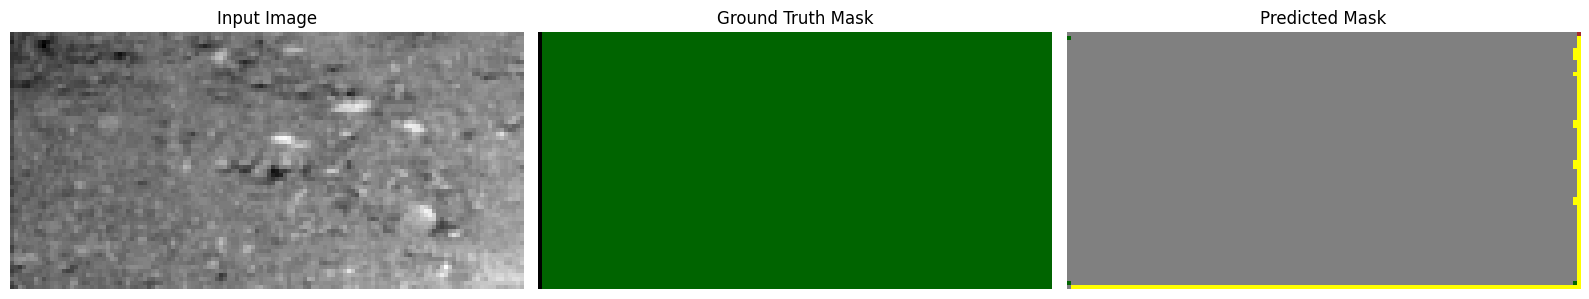

32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 562ms/step - accuracy: 0.2505 - loss: 1.7917 - mean_iou: 0.1233 - val_accuracy: 0.2035 - val_loss: 1.5815 - val_mean_iou: 0.0727 - learning_rate: 0.0010
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.4758 - loss: 1.3440 - mean_iou: 0.2354 - val_accuracy: 0.2551 - val_loss: 1.5491 - val_mean_iou: 0.1183 - learning_rate: 0.0010
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.5441 - loss: 1.1800 - mean_iou: 0.2805 - val_accuracy: 0.2012 - val_loss: 1.5942 - val_mean_iou: 0.0705 - learning_rate: 0.0010
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.5911 - loss: 1.0621 - mean_iou: 0.3158 - val_accuracy: 0.2007 - val_loss: 1.6434 - val_mean_iou: 0.0557 - learning_rate: 0.0010
Epoch 5/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.5959 - loss: 1.0356 - mean_iou: 0.3174 - val_accuracy: 0.1994 - val_loss: 1.8047 - val_mean_iou: 0.0672 - learning_rate: 0.0010
Epoch 6/1000
32/32 ━━━━━━━━━━━━━

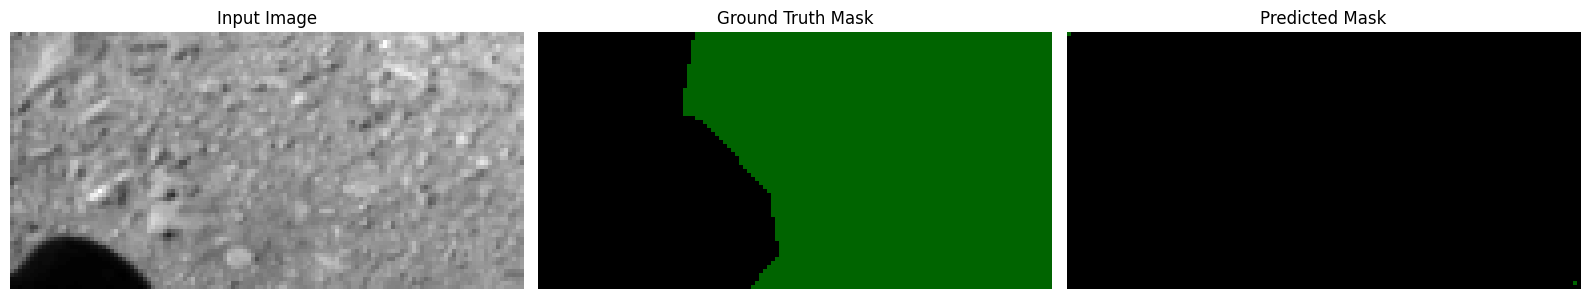

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.6273 - loss: 0.9561 - mean_iou: 0.3441 - val_accuracy: 0.1981 - val_loss: 1.9532 - val_mean_iou: 0.0659 - learning_rate: 0.0010
Epoch 7/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.6329 - loss: 0.9453 - mean_iou: 0.3413 - val_accuracy: 0.1979 - val_loss: 2.2090 - val_mean_iou: 0.0657 - learning_rate: 0.0010
Epoch 8/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.6541 - loss: 0.9048 - mean_iou: 0.3650 - val_accuracy: 0.1989 - val_loss: 2.3311 - val_mean_iou: 0.0526 - learning_rate: 0.0010
Epoch 9/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.6652 - loss: 0.8626 - mean_iou: 0.3813 - val_accuracy: 0.1988 - val_loss: 2.4000 - val_mean_iou: 0.0532 - learning_rate: 0.0010
Epoch 10/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.6600 - loss: 0.8832 - mean_iou: 0.3752 - val_accuracy: 0.1989 - val_loss: 2.5518 - val_mean_iou: 0.0530 - learning_rate: 0.0010
Epoch 11/1000
32/32 ━━━━━━━━━━━━

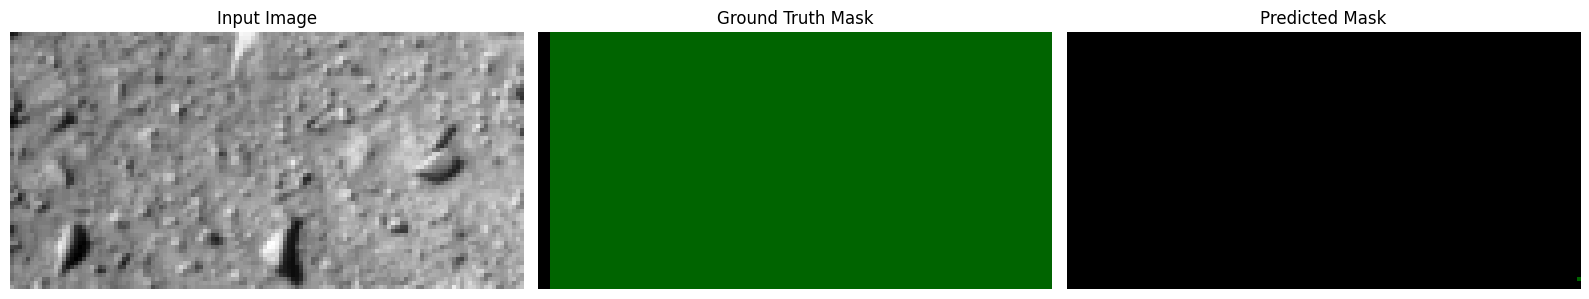

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.6761 - loss: 0.8566 - mean_iou: 0.3859 - val_accuracy: 0.2221 - val_loss: 2.6940 - val_mean_iou: 0.0680 - learning_rate: 0.0010
Epoch 12/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.6800 - loss: 0.8299 - mean_iou: 0.3923 - val_accuracy: 0.2410 - val_loss: 2.8615 - val_mean_iou: 0.0769 - learning_rate: 0.0010
Epoch 13/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.7065 - loss: 0.7706 - mean_iou: 0.4161 - val_accuracy: 0.2710 - val_loss: 2.5618 - val_mean_iou: 0.0969 - learning_rate: 1.0000e-04
Epoch 14/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.7254 - loss: 0.7289 - mean_iou: 0.4357 - val_accuracy: 0.3241 - val_loss: 2.2078 - val_mean_iou: 0.1297 - learning_rate: 1.0000e-04
Epoch 15/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.7270 - loss: 0.7244 - mean_iou: 0.4362 - val_accuracy: 0.3646 - val_loss: 1.9666 - val_mean_iou: 0.1533 - learning_rate: 1.0000e-04
Epoch 16/1000
32/

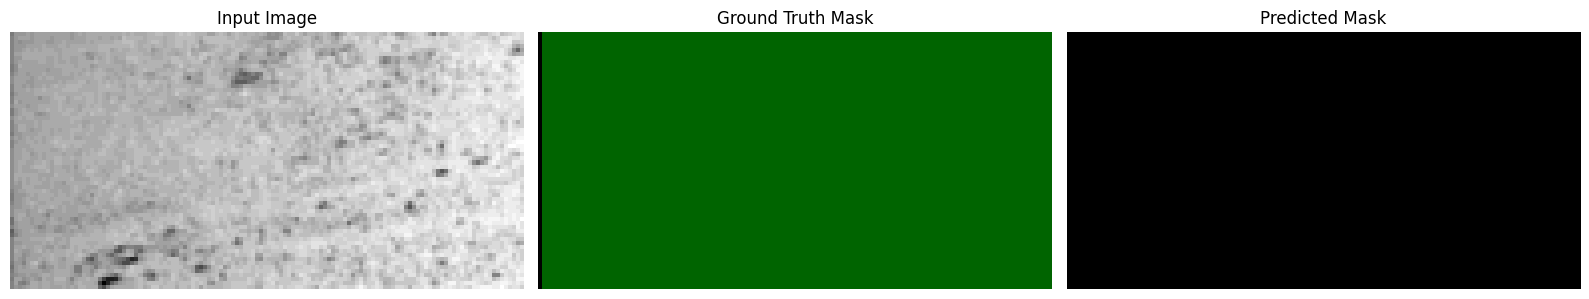

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.7313 - loss: 0.7104 - mean_iou: 0.4411 - val_accuracy: 0.4113 - val_loss: 1.7448 - val_mean_iou: 0.1833 - learning_rate: 1.0000e-04
Epoch 17/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.7366 - loss: 0.7055 - mean_iou: 0.4425 - val_accuracy: 0.4761 - val_loss: 1.4838 - val_mean_iou: 0.2309 - learning_rate: 1.0000e-04
Epoch 18/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.7339 - loss: 0.7025 - mean_iou: 0.4420 - val_accuracy: 0.5415 - val_loss: 1.2566 - val_mean_iou: 0.2819 - learning_rate: 1.0000e-04
Epoch 19/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.7396 - loss: 0.6878 - mean_iou: 0.4472 - val_accuracy: 0.5892 - val_loss: 1.1128 - val_mean_iou: 0.3211 - learning_rate: 1.0000e-04
Epoch 20/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.7406 - loss: 0.6898 - mean_iou: 0.4505 - val_accuracy: 0.6305 - val_loss: 0.9679 - val_mean_iou: 0.3573 - learning_rate: 1.0000e-04
Epoch 21/

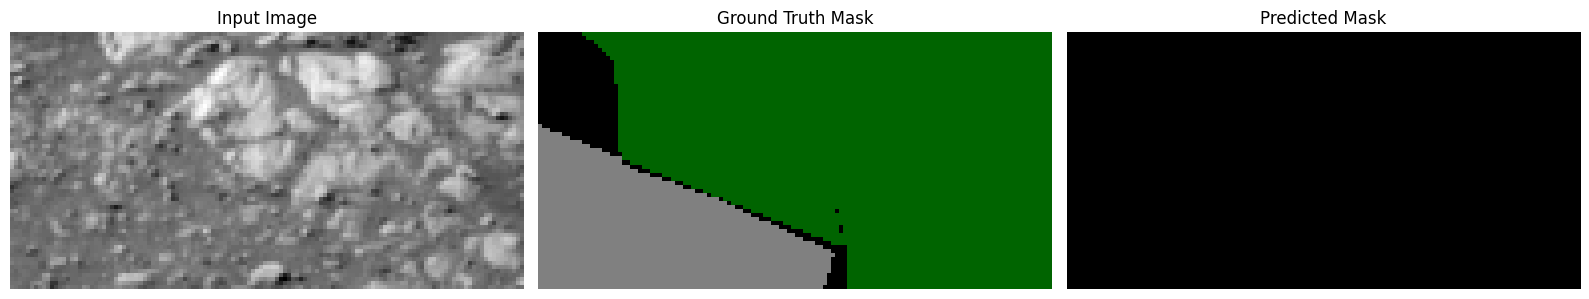

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.7320 - loss: 0.6995 - mean_iou: 0.4330 - val_accuracy: 0.6665 - val_loss: 0.8546 - val_mean_iou: 0.3824 - learning_rate: 1.0000e-04
Epoch 22/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 0.7413 - loss: 0.6913 - mean_iou: 0.4469 - val_accuracy: 0.6869 - val_loss: 0.8225 - val_mean_iou: 0.4083 - learning_rate: 1.0000e-04
Epoch 23/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - accuracy: 0.7477 - loss: 0.6698 - mean_iou: 0.4499 - val_accuracy: 0.6805 - val_loss: 0.8407 - val_mean_iou: 0.3931 - learning_rate: 1.0000e-04
Epoch 24/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.7480 - loss: 0.6718 - mean_iou: 0.4524 - val_accuracy: 0.7121 - val_loss: 0.7645 - val_mean_iou: 0.4259 - learning_rate: 1.0000e-04
Epoch 25/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.7505 - loss: 0.6672 - mean_iou: 0.4534 - val_accuracy: 0.6932 - val_loss: 0.8023 - val_mean_iou: 0.4027 - learning_rate: 1.0000e-04
Epoch 26

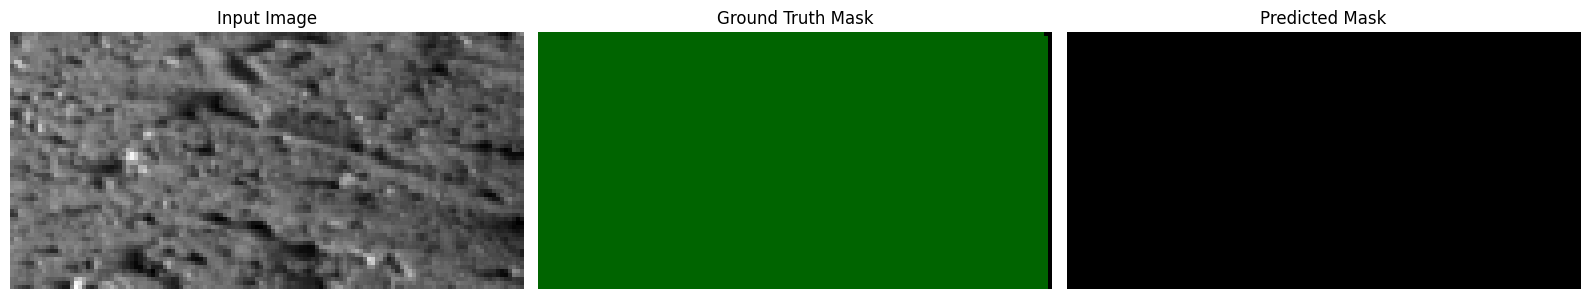

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - accuracy: 0.7532 - loss: 0.6624 - mean_iou: 0.4590 - val_accuracy: 0.7183 - val_loss: 0.7505 - val_mean_iou: 0.4267 - learning_rate: 1.0000e-04
Epoch 27/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - accuracy: 0.7559 - loss: 0.6529 - mean_iou: 0.4552 - val_accuracy: 0.6751 - val_loss: 0.8723 - val_mean_iou: 0.3703 - learning_rate: 1.0000e-04
Epoch 28/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.7502 - loss: 0.6605 - mean_iou: 0.4528 - val_accuracy: 0.7346 - val_loss: 0.7087 - val_mean_iou: 0.4423 - learning_rate: 1.0000e-04
Epoch 29/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.7533 - loss: 0.6524 - mean_iou: 0.4575 - val_accuracy: 0.7314 - val_loss: 0.7201 - val_mean_iou: 0.4361 - learning_rate: 1.0000e-04
Epoch 30/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.7566 - loss: 0.6409 - mean_iou: 0.4599 - val_accuracy: 0.7256 - val_loss: 0.7422 - val_mean_iou: 0.4259 - learning_rate: 1.0000e-04
Epoch 3

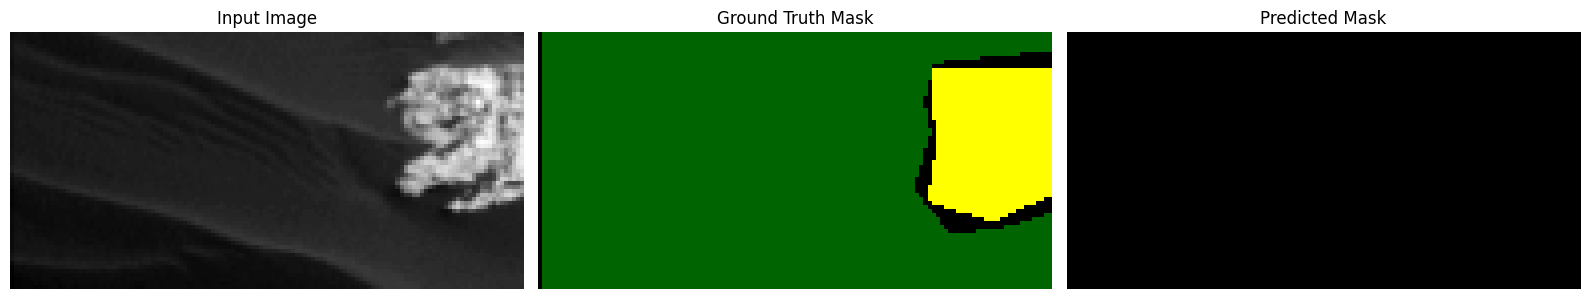

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - accuracy: 0.7509 - loss: 0.6562 - mean_iou: 0.4499 - val_accuracy: 0.7202 - val_loss: 0.7513 - val_mean_iou: 0.4204 - learning_rate: 1.0000e-04
Epoch 32/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.7534 - loss: 0.6511 - mean_iou: 0.4528 - val_accuracy: 0.7352 - val_loss: 0.7223 - val_mean_iou: 0.4368 - learning_rate: 1.0000e-04
Epoch 33/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.7639 - loss: 0.6325 - mean_iou: 0.4610 - val_accuracy: 0.7335 - val_loss: 0.7215 - val_mean_iou: 0.4314 - learning_rate: 1.0000e-04
Epoch 34/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.7658 - loss: 0.6237 - mean_iou: 0.4638 - val_accuracy: 0.7241 - val_loss: 0.7567 - val_mean_iou: 0.4238 - learning_rate: 1.0000e-04
Epoch 35/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.7688 - loss: 0.6153 - mean_iou: 0.4679 - val_accuracy: 0.7325 - val_loss: 0.7310 - val_mean_iou: 0.4301 - learning_rate: 1.0000e-04
Epoch 3

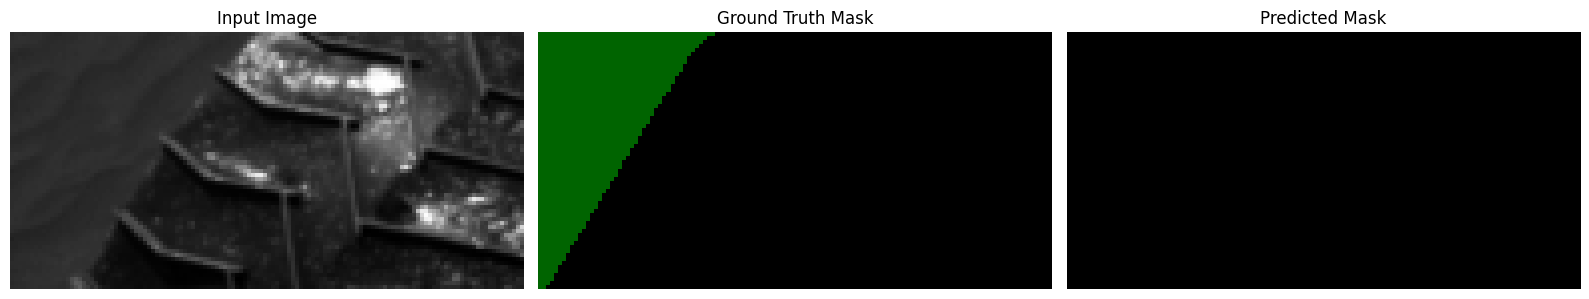

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 0.7705 - loss: 0.6125 - mean_iou: 0.4770 - val_accuracy: 0.7279 - val_loss: 0.7419 - val_mean_iou: 0.4291 - learning_rate: 1.0000e-04
Epoch 37/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.7670 - loss: 0.6206 - mean_iou: 0.4663 - val_accuracy: 0.7388 - val_loss: 0.7020 - val_mean_iou: 0.4379 - learning_rate: 1.0000e-04
Epoch 38/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.7713 - loss: 0.6151 - mean_iou: 0.4700 - val_accuracy: 0.7434 - val_loss: 0.6988 - val_mean_iou: 0.4413 - learning_rate: 1.0000e-04
Epoch 39/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.7776 - loss: 0.5976 - mean_iou: 0.4754 - val_accuracy: 0.7460 - val_loss: 0.6851 - val_mean_iou: 0.4418 - learning_rate: 1.0000e-05
Epoch 40/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.7750 - loss: 0.6024 - mean_iou: 0.4753 - val_accuracy: 0.7476 - val_loss: 0.6751 - val_mean_iou: 0.4436 - learning_rate: 1.0000e-05
Epoch 41/

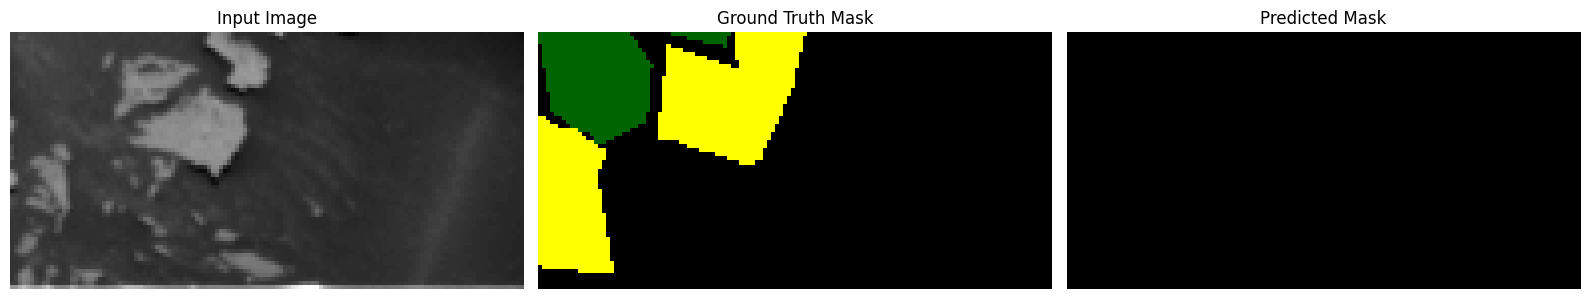

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - accuracy: 0.7787 - loss: 0.5951 - mean_iou: 0.4801 - val_accuracy: 0.7487 - val_loss: 0.6719 - val_mean_iou: 0.4444 - learning_rate: 1.0000e-05
Epoch 42/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.7819 - loss: 0.5851 - mean_iou: 0.4790 - val_accuracy: 0.7497 - val_loss: 0.6696 - val_mean_iou: 0.4451 - learning_rate: 1.0000e-05
Epoch 43/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.7772 - loss: 0.5929 - mean_iou: 0.4772 - val_accuracy: 0.7509 - val_loss: 0.6678 - val_mean_iou: 0.4467 - learning_rate: 1.0000e-05
Epoch 44/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.7753 - loss: 0.6000 - mean_iou: 0.4780 - val_accuracy: 0.7504 - val_loss: 0.6699 - val_mean_iou: 0.4459 - learning_rate: 1.0000e-05
Epoch 45/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.7789 - loss: 0.5909 - mean_iou: 0.4769 - val_accuracy: 0.7498 - val_loss: 0.6715 - val_mean_iou: 0.4446 - learning_rate: 1.0000e-05
Epoch 46

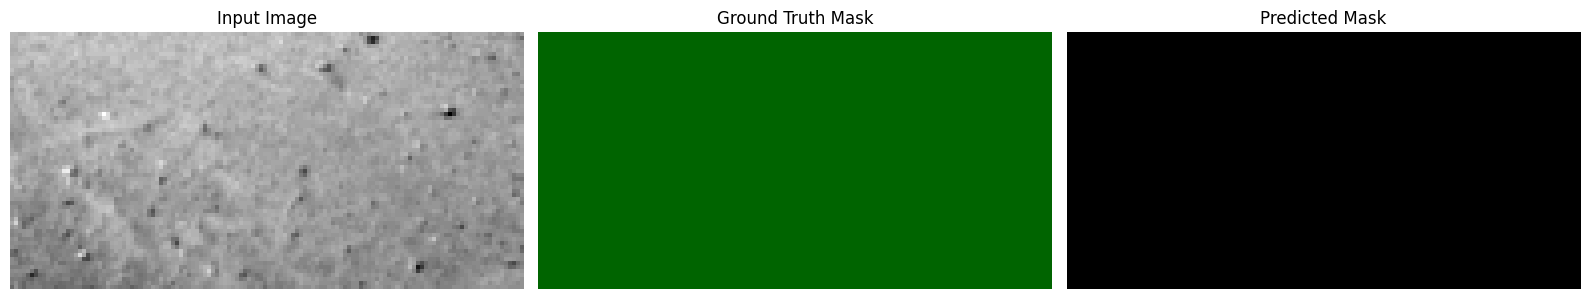

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.7774 - loss: 0.5927 - mean_iou: 0.4780 - val_accuracy: 0.7506 - val_loss: 0.6708 - val_mean_iou: 0.4454 - learning_rate: 1.0000e-05
Epoch 47/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.7831 - loss: 0.5875 - mean_iou: 0.4807 - val_accuracy: 0.7514 - val_loss: 0.6701 - val_mean_iou: 0.4466 - learning_rate: 1.0000e-05
Epoch 48/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.7818 - loss: 0.5821 - mean_iou: 0.4835 - val_accuracy: 0.7517 - val_loss: 0.6707 - val_mean_iou: 0.4472 - learning_rate: 1.0000e-05
Epoch 49/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.7806 - loss: 0.5855 - mean_iou: 0.4768 - val_accuracy: 0.7502 - val_loss: 0.6709 - val_mean_iou: 0.4443 - learning_rate: 1.0000e-05
Epoch 50/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.7810 - loss: 0.5868 - mean_iou: 0.4818 - val_accuracy: 0.7506 - val_loss: 0.6706 - val_mean_iou: 0.4449 - learning_rate: 1.0000e-05
Epoch 51

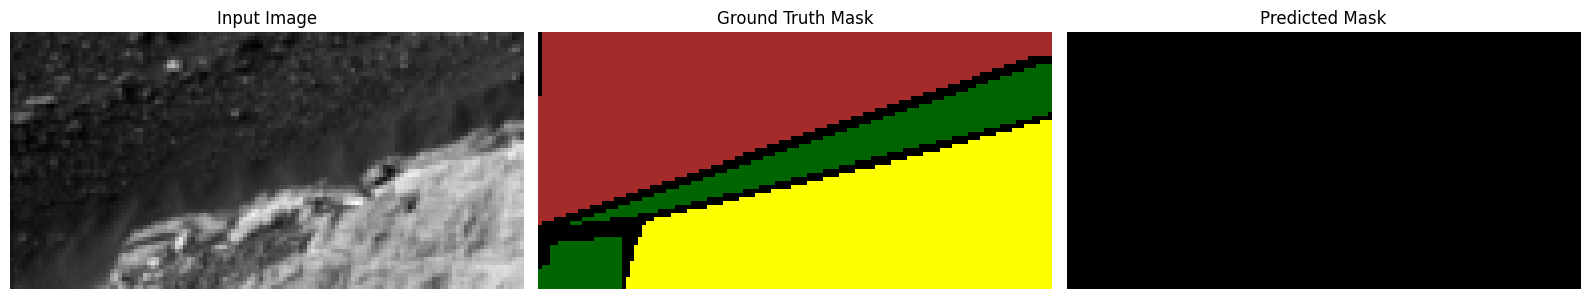

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.7857 - loss: 0.5814 - mean_iou: 0.4847 - val_accuracy: 0.7509 - val_loss: 0.6703 - val_mean_iou: 0.4457 - learning_rate: 1.0000e-05
Epoch 52/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.7808 - loss: 0.5811 - mean_iou: 0.4821 - val_accuracy: 0.7516 - val_loss: 0.6700 - val_mean_iou: 0.4468 - learning_rate: 1.0000e-05
Epoch 53/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.7784 - loss: 0.5869 - mean_iou: 0.4797 - val_accuracy: 0.7499 - val_loss: 0.6738 - val_mean_iou: 0.4443 - learning_rate: 1.0000e-05
Epoch 54/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.7812 - loss: 0.5844 - mean_iou: 0.4837 - val_accuracy: 0.7504 - val_loss: 0.6732 - val_mean_iou: 0.4449 - learning_rate: 1.0000e-05
Epoch 55/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.7816 - loss: 0.5846 - mean_iou: 0.4787 - val_accuracy: 0.7506 - val_loss: 0.6724 - val_mean_iou: 0.4446 - learning_rate: 1.0000e-05
Epoch 5

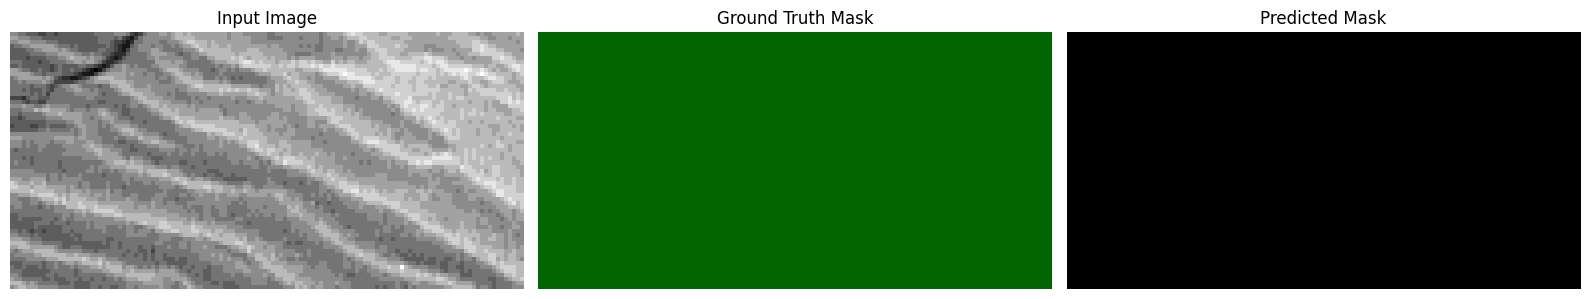

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - accuracy: 0.7845 - loss: 0.5783 - mean_iou: 0.4848 - val_accuracy: 0.7509 - val_loss: 0.6719 - val_mean_iou: 0.4452 - learning_rate: 1.0000e-05
Epoch 57/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - accuracy: 0.7806 - loss: 0.5862 - mean_iou: 0.4836 - val_accuracy: 0.7519 - val_loss: 0.6700 - val_mean_iou: 0.4471 - learning_rate: 1.0000e-05
Epoch 58/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.7842 - loss: 0.5764 - mean_iou: 0.4823 - val_accuracy: 0.7510 - val_loss: 0.6714 - val_mean_iou: 0.4449 - learning_rate: 1.0000e-05
Epoch 59/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.7870 - loss: 0.5692 - mean_iou: 0.4905 - val_accuracy: 0.7512 - val_loss: 0.6703 - val_mean_iou: 0.4452 - learning_rate: 1.0000e-06
Epoch 60/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.7850 - loss: 0.5801 - mean_iou: 0.4851 - val_accuracy: 0.7512 - val_loss: 0.6700 - val_mean_iou: 0.4451 - learning_rate: 1.0000e-06
Epoch 61

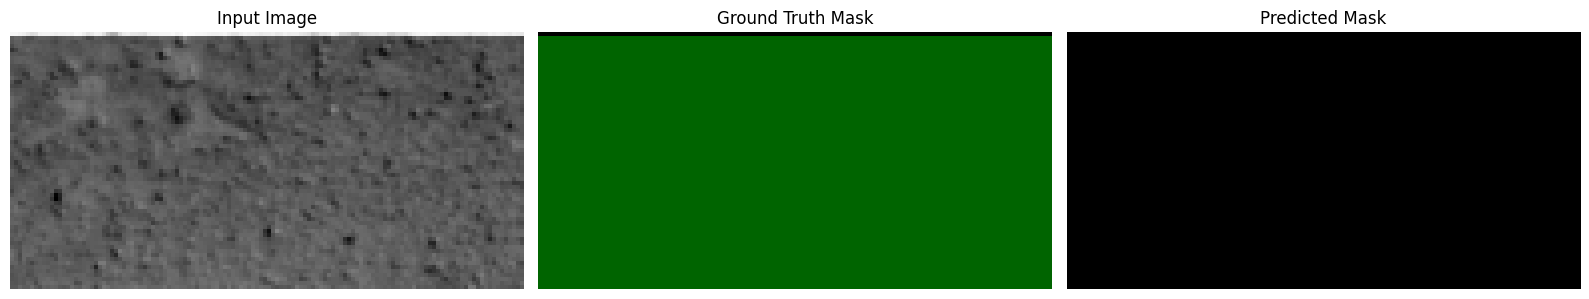

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.7828 - loss: 0.5780 - mean_iou: 0.4826 - val_accuracy: 0.7513 - val_loss: 0.6698 - val_mean_iou: 0.4452 - learning_rate: 1.0000e-06
Epoch 62/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.7853 - loss: 0.5730 - mean_iou: 0.4856 - val_accuracy: 0.7513 - val_loss: 0.6703 - val_mean_iou: 0.4449 - learning_rate: 1.0000e-06
Epoch 63/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.7823 - loss: 0.5804 - mean_iou: 0.4822 - val_accuracy: 0.7510 - val_loss: 0.6706 - val_mean_iou: 0.4445 - learning_rate: 1.0000e-06
Epoch 64/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.7793 - loss: 0.5899 - mean_iou: 0.4808 - val_accuracy: 0.7511 - val_loss: 0.6705 - val_mean_iou: 0.4448 - learning_rate: 1.0000e-06
Epoch 65/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.7853 - loss: 0.5735 - mean_iou: 0.4861 - val_accuracy: 0.7511 - val_loss: 0.6704 - val_mean_iou: 0.4448 - learning_rate: 1.0000e-06
Epoch 66/

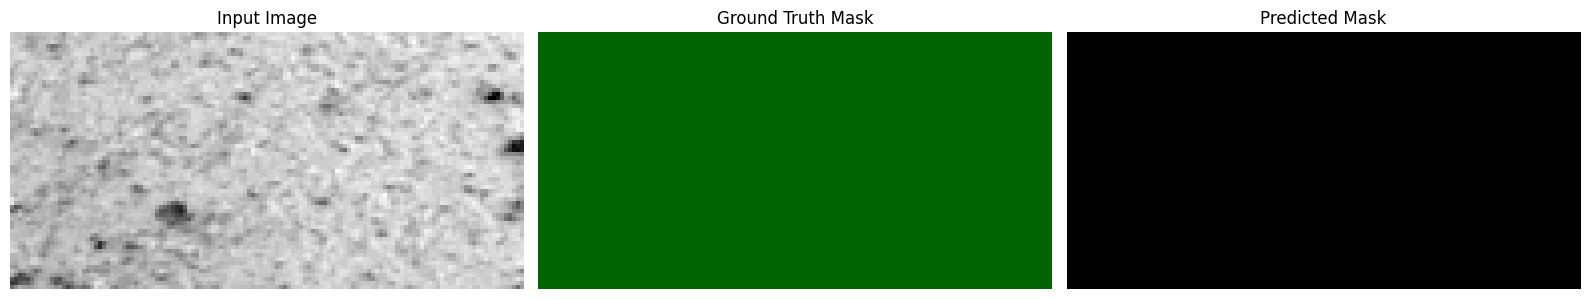

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.7868 - loss: 0.5728 - mean_iou: 0.4825 - val_accuracy: 0.7511 - val_loss: 0.6703 - val_mean_iou: 0.4448 - learning_rate: 1.0000e-06
Epoch 67/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.7860 - loss: 0.5733 - mean_iou: 0.4854 - val_accuracy: 0.7512 - val_loss: 0.6703 - val_mean_iou: 0.4450 - learning_rate: 1.0000e-06
Epoch 68/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.7804 - loss: 0.5942 - mean_iou: 0.4776 - val_accuracy: 0.7513 - val_loss: 0.6702 - val_mean_iou: 0.4451 - learning_rate: 1.0000e-06
Epoch 69/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.7845 - loss: 0.5771 - mean_iou: 0.4804 - val_accuracy: 0.7513 - val_loss: 0.6704 - val_mean_iou: 0.4448 - learning_rate: 1.0000e-07
Epoch 70/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.7842 - loss: 0.5778 - mean_iou: 0.4872 - val_accuracy: 0.7513 - val_loss: 0.6702 - val_mean_iou: 0.4448 - learning_rate: 1.0000e-07
Epoch 7

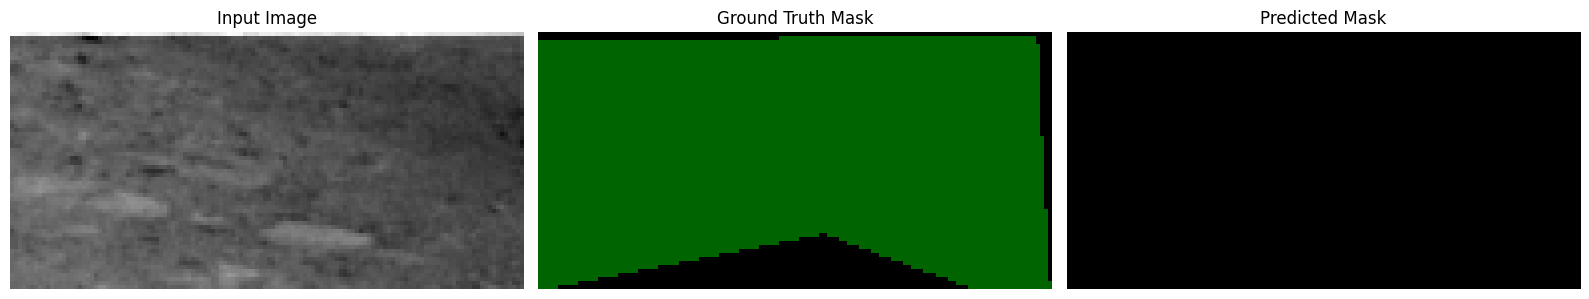

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - accuracy: 0.7809 - loss: 0.5798 - mean_iou: 0.4788 - val_accuracy: 0.7512 - val_loss: 0.6706 - val_mean_iou: 0.4446 - learning_rate: 1.0000e-07
Epoch 72/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.7805 - loss: 0.5837 - mean_iou: 0.4832 - val_accuracy: 0.7512 - val_loss: 0.6704 - val_mean_iou: 0.4446 - learning_rate: 1.0000e-07
Epoch 73/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.7821 - loss: 0.5879 - mean_iou: 0.4842 - val_accuracy: 0.7512 - val_loss: 0.6705 - val_mean_iou: 0.4447 - learning_rate: 1.0000e-07
Epoch 74/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.7822 - loss: 0.5856 - mean_iou: 0.4843 - val_accuracy: 0.7511 - val_loss: 0.6705 - val_mean_iou: 0.4446 - learning_rate: 1.0000e-07
Epoch 75/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.7790 - loss: 0.5871 - mean_iou: 0.4801 - val_accuracy: 0.7512 - val_loss: 0.6703 - val_mean_iou: 0.4447 - learning_rate: 1.0000e-07
Epoch 76

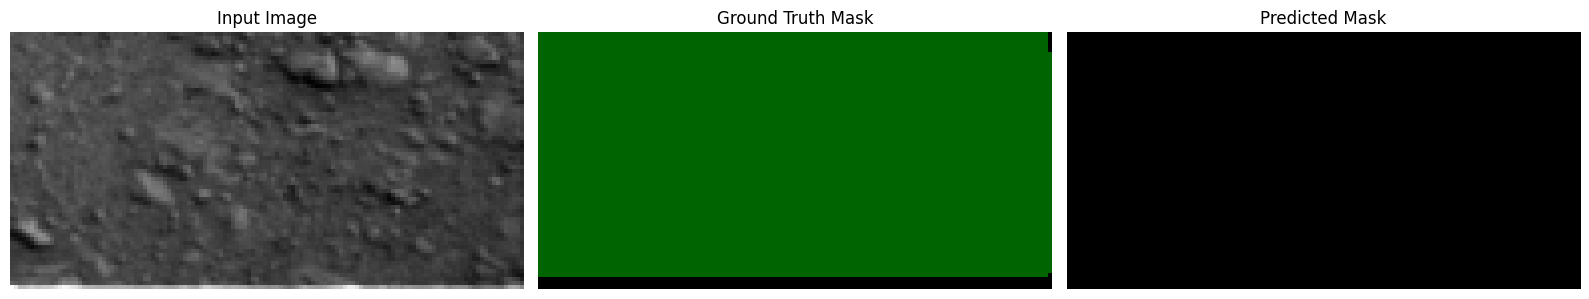

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - accuracy: 0.7809 - loss: 0.5820 - mean_iou: 0.4854 - val_accuracy: 0.7512 - val_loss: 0.6703 - val_mean_iou: 0.4447 - learning_rate: 1.0000e-07
Epoch 77/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - accuracy: 0.7865 - loss: 0.5716 - mean_iou: 0.4880 - val_accuracy: 0.7511 - val_loss: 0.6704 - val_mean_iou: 0.4446 - learning_rate: 1.0000e-07
Epoch 78/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.7871 - loss: 0.5697 - mean_iou: 0.4836 - val_accuracy: 0.7510 - val_loss: 0.6705 - val_mean_iou: 0.4446 - learning_rate: 1.0000e-07
Final validation Mean Intersection Over Union: 44.72%


In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_plateau, viz_callback],
    verbose=1
).history


# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

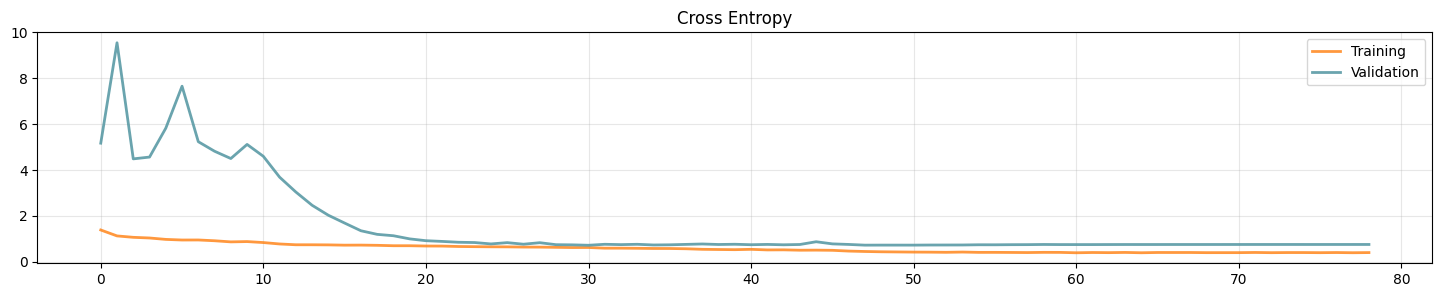

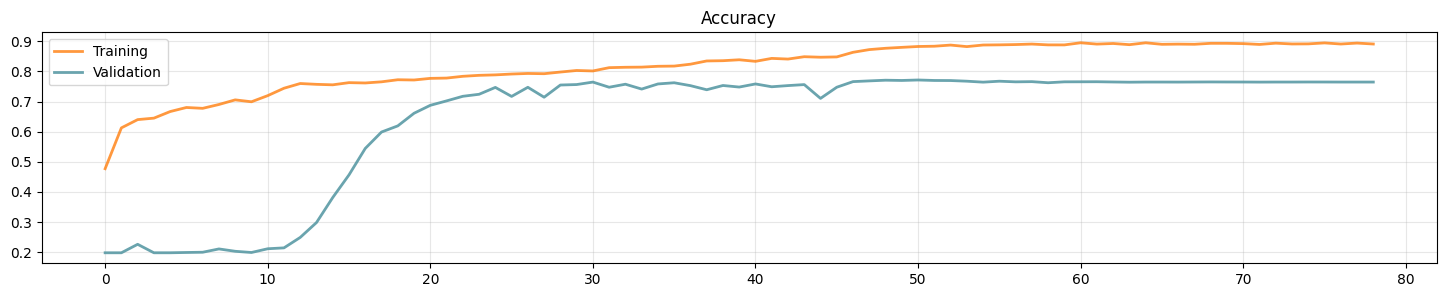

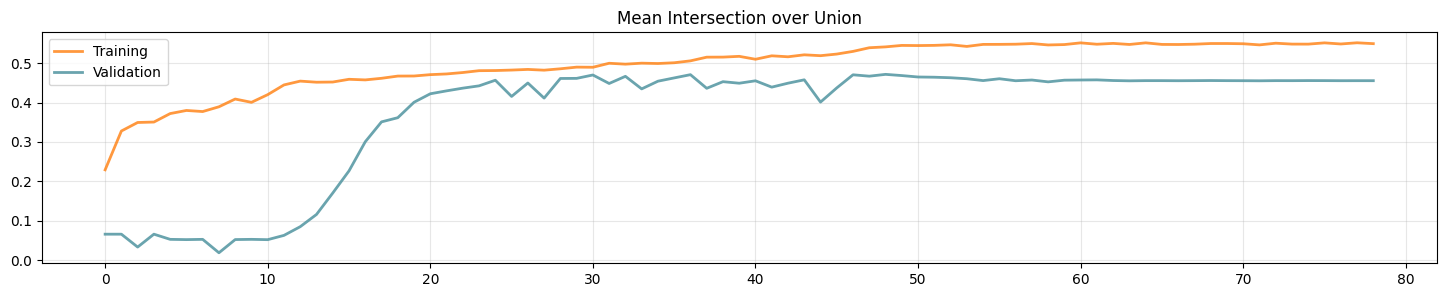

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Visualize prediction validation set

In [ ]:
y_val_pred = model.predict(val_dataset)
y_val_pred = np.argmax(y_val_pred, axis=-1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step


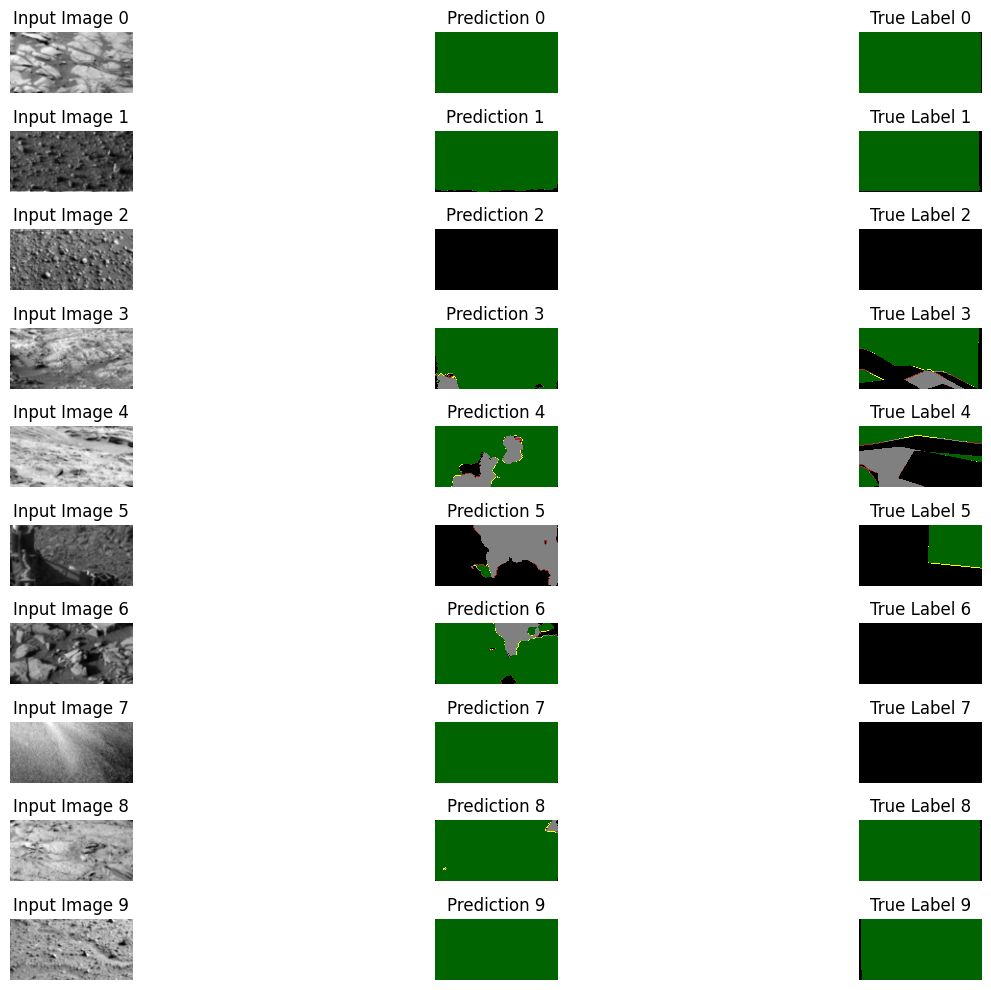

In [ ]:
def display_images_with_predictions_and_true_labels(input_images, predictions, true_labels, start=0, end=5, figsize=(15, 10)):
    """
    Display input images, model predictions, and true labels for visual comparison.

    Parameters:
    - input_images: Array of input images (e.g., grayscale terrain images).
    - predictions: Array of predicted segmentation masks (output from the model).
    - true_labels: Array of ground truth segmentation masks.
    - start: Index to start the display from.
    - end: Index to stop the display at (inclusive).
    - figsize: Size of the figure for plotting.
    """

    # Set up the figure for displaying images
    fig, axes = plt.subplots(end - start, 3, figsize=figsize)

    for i in range(start, end):
        # Display the input image
        axes[i-start, 0].imshow(input_images[i, :, :, 0], cmap='gray')
        axes[i-start, 0].set_title(f'Input Image {i}')
        axes[i-start, 0].axis('off')

        # Display the predicted mask
        axes[i-start, 1].imshow(predictions[i, :, :], cmap=cmap)  # Use a color map for prediction
        axes[i-start, 1].set_title(f'Prediction {i}')
        axes[i-start, 1].axis('off')

        # Display the true mask
        axes[i-start, 2].imshow(true_labels[i, :, :], cmap=cmap)  # Use the same color map for ground truth
        axes[i-start, 2].set_title(f'True Label {i}')
        axes[i-start, 2].axis('off')

    plt.tight_layout()
    plt.show()

display_images_with_predictions_and_true_labels(val_img, y_val_pred, val_lbl, start=0, end=10)

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

def compute_metrics(y_true, y_pred, num_classes=5):
    """
    Compute precision, recall, and accuracy for segmentation tasks.
    Parameters:
    - y_true: Ground truth labels (numpy array).
    - y_pred: Predicted labels (numpy array).
    - num_classes: Number of classes (including background).

    Returns:
    - precision: Per-class precision.
    - recall: Per-class recall.
    - accuracy: Overall accuracy.
    """
    # Flatten the arrays for metric calculation
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Precision and Recall for each class
    precision = precision_score(y_true_flat, y_pred_flat, average=None, labels=np.arange(num_classes))
    recall = recall_score(y_true_flat, y_pred_flat, average=None, labels=np.arange(num_classes))

    # Overall Accuracy
    accuracy = accuracy_score(y_true_flat, y_pred_flat)

    return precision, recall, accuracy

# Compute metrics
precision, recall, accuracy = compute_metrics(val_lbl, y_val_pred, num_classes=5)

# Print results
print(f"Precision (per class): {precision}")
print(f"Recall (per class): {recall}")
print(f"Overall Accuracy: {accuracy}")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision (per class): [0.70028455 0.81402045 0.69656847 0.84335913 0.        ]
Recall (per class): [0.51614329 0.89730219 0.80906506 0.83034782 0.        ]
Overall Accuracy: 0.770800927441991


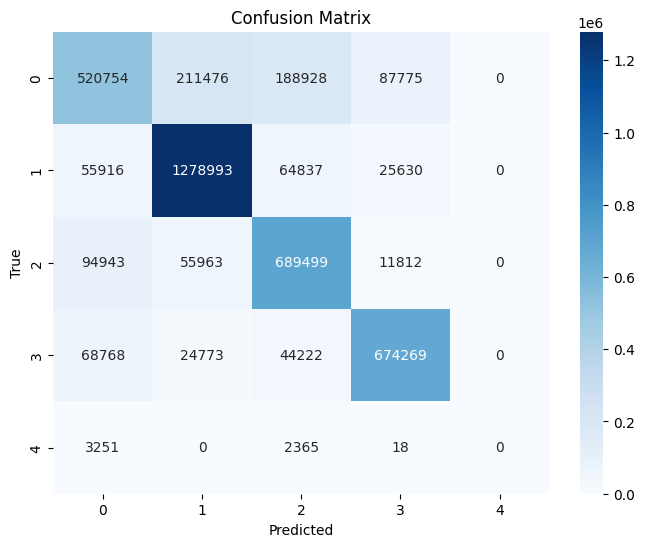

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, num_classes=num_classes):
    cm = confusion_matrix(y_true.flatten(), y_pred.flatten(), labels=np.arange(num_classes))

    # Plot confusion matrix using Seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(val_lbl, y_val_pred)

**Observation**: From the confusion matrix we note that class 4 is hardly classified. In addition, we have errors in the classification of the other classes, especially class 0, and the other classes are highly confused. Most of the misclassifications that we wish to correct are False Positives. This can be done by working on the structure of the network as well as, for example, the choice of loss function.

The attention meachaniscm itself do not lead to a significant improvement.

In [ ]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Model saved to model_241204_142752.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [ ]:
model = tfk.models.load_model(model_filename)
print(f"Model loaded from {model_filename}")

Model loaded from model_241204_142752.keras


In [ ]:
preds = model.predict(test_dataset)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step
Predictions shape: (10022, 64, 128)


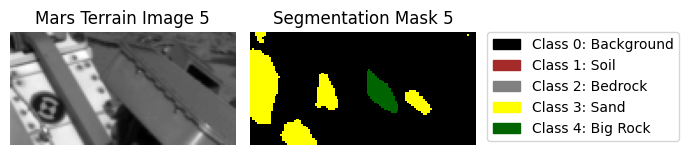

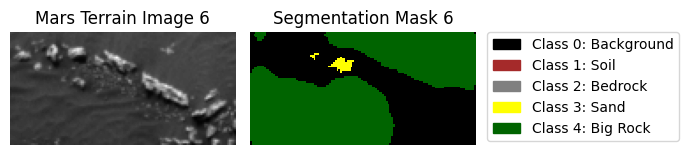

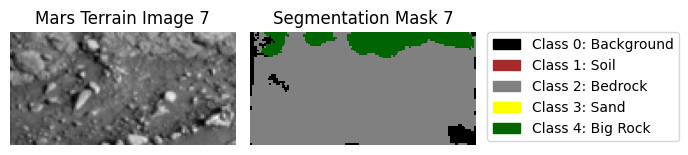

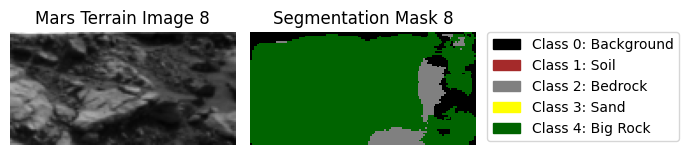

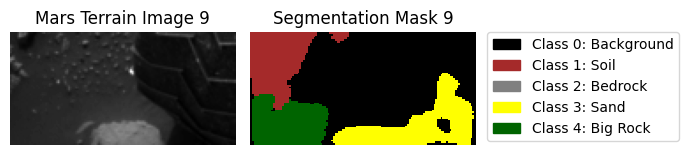

In [ ]:
# Visualize pred and image refere
display_images_with_masks(X_test, preds, start=5, end=10)

In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)
print(f"Submission file saved to {submission_filename}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Submission file saved to submission_241204_142752.csv
